### About
Multiclass classification on 10 types of clothing using the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist).  This is meant to be a more challenging version of MNIST.

#### Accuracy
- Mine: 0.931
- [SOTA](https://github.com/zalandoresearch/fashion-mnist): 0.967

### Setup
Load the fastai libraries.

In [1]:
from fastai import *
from fastai.vision import *
import torchvision

### Data
Download the dataset.  Pytorch provides the dataset and does the work of transforming it into images with labels.  I couldn't figure out how to load pytorch datasets into fastai so I just saved the images out to disk using imagenet style labeling.

In [2]:
data_dir = '/root/.fastai/data/'
os.makedirs(data_dir, exist_ok=True)
training_ds = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_ds = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

In [3]:
training_ds

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /root/.fastai/data/
    Transforms (if any): None
    Target Transforms (if any): None

In [4]:
test_ds

Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /root/.fastai/data/
    Transforms (if any): None
    Target Transforms (if any): None

In [10]:
# convert pytorch dataset to imagenet style folders with images
def ds2folder(ds, path):
    path = str(path)
    for i in range(len(ds)):
        img = ds[i][0]
        label = ds[i][1]
        os.makedirs(f'{path}/{label}', exist_ok=True)
        img.save(f'{path}/{label}/{i}.bmp')

In [11]:
path = Path(data_dir + 'FashionMNIST')

In [12]:
ds2folder(training_ds, path/'training')

In [13]:
ds2folder(test_ds, path/'test')

### Model
Create the model.  Use a resnet pre-trained on imagenet.  Only do rotation and zoom for data augmentation.  Labeled data is already split into training and validation sets.  There is no unlabeled test data.

In [14]:
bs = 64
num_workers = 8
size = 28
model = models.resnet18

In [15]:
#tfms = get_transforms(do_flip=False, max_lighting=0., max_warp=0., p_lighting=0.)
#tfms = get_transforms(max_warp=0., p_lighting=0.)
tfms = get_transforms(do_flip=False, max_warp=0., p_lighting=0., )

In [16]:
src = (ImageList.from_folder(path)
       .split_by_folder(train='training', valid='test')
       .label_from_folder())

In [17]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [18]:
learn = cnn_learner(data, model, metrics=[accuracy])

In [19]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 14, 14]         128        True      
______________________________________________________________________
ReLU                 [64, 14, 14]         0          False     
______________________________________________________________________
MaxPool2d            [64, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 7, 7]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 7, 7]           128        True      
______________________________________________________________________
ReLU                 [64, 7, 7]           0          False     
______________________________________________________________

### Train
Run the learning rate finder and train the model using 1-cycle learning.

In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


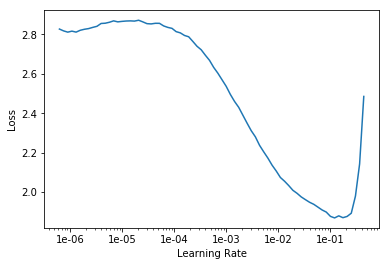

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(7, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.475819,0.428826,0.849600,00:23
1,0.456204,0.447116,0.828100,00:23
2,0.365450,0.303895,0.891300,00:22
3,0.295299,0.261795,0.902100,00:21
4,0.247534,0.243486,0.908200,00:21
5,0.207852,0.210958,0.921200,00:23
6,0.189364,0.208035,0.923200,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


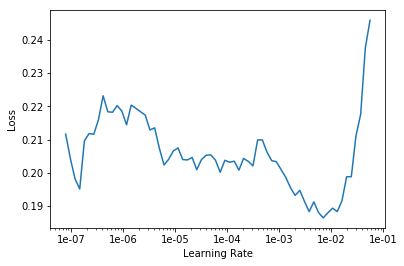

In [24]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(7, max_lr=slice(4e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.198589,0.210278,0.923500,00:23
1,0.191460,0.214392,0.919300,00:23
2,0.191071,0.208897,0.924400,00:22
3,0.163538,0.206827,0.926500,00:23
4,0.159099,0.203161,0.928000,00:22
5,0.141438,0.198968,0.931200,00:22
6,0.133545,0.200709,0.928800,00:22


### Results
Dig into the results by looking at the confusion matrix and plotting top losses.

In [26]:
preds, targs, losses = learn.get_preds(with_loss=True)

In [27]:
interp = ClassificationInterpretation(learn, preds, targs, losses)

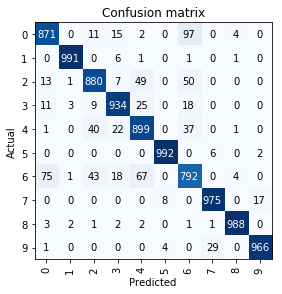

In [28]:
interp.plot_confusion_matrix()

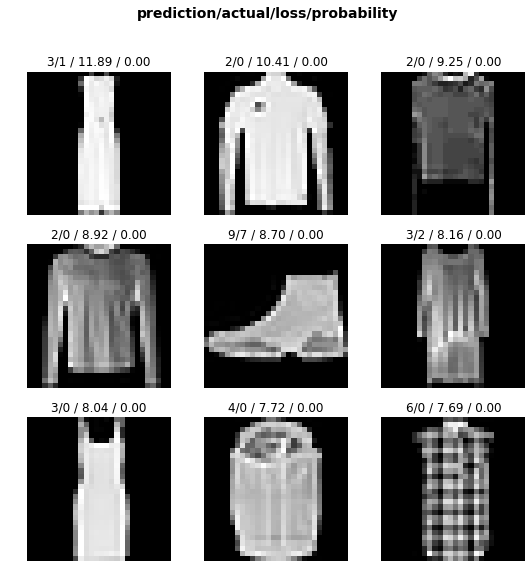

In [29]:
interp.plot_top_losses(9, figsize=(9, 9))

In [30]:
interp.most_confused(9)

[('0', '6', 97),
 ('6', '0', 75),
 ('6', '4', 67),
 ('2', '6', 50),
 ('2', '4', 49),
 ('6', '2', 43),
 ('4', '2', 40),
 ('4', '6', 37),
 ('9', '7', 29),
 ('3', '4', 25),
 ('4', '3', 22),
 ('3', '6', 18),
 ('6', '3', 18),
 ('7', '9', 17),
 ('0', '3', 15),
 ('2', '0', 13),
 ('0', '2', 11),
 ('3', '0', 11),
 ('3', '2', 9)]

In [31]:
# total number of incorrect predictions
int(torch.sum(interp.pred_class != interp.y_true))

712